In [1]:
import os
import re
import io
import gzip
import requests
import pandas as pd
import geopandas as gpd
import numpy as np
import requests
from shapely.ops import nearest_points
from shapely.geometry import Point
import scipy.stats as st

In [42]:
def confidence_interval(data, conf=0.9):
    """ Computes the confidence interval of an input distribution using either t-score or z-score 
    depending on the available number of samples """
    if len(data) >= 30:
        return st.norm.interval(alpha=conf, loc=np.mean(data), scale=st.sem(data))
    return st.t.interval(alpha=conf, df=len(data)-1, loc=np.mean(data), scale=st.sem(data)) 

In [43]:
def sample(data, intervals=[0.9]):
    mean = np.mean(data)
    bounds = {}
    for i in intervals: 
        low, upp = confidence_interval(data, i)
        bounds[f'lower_{i}'] = low
        bounds[f'upper_{i}'] = upp
    return {
        'mean': mean,
        **bounds
    }

# Readme:

This notebook leads you through querying temperature, precipitation and evaporation data from the respectively closest weather station(s) to a specified coordinate pair.

Temperature and precipitation are queried from meteostats api, for which a valid api key obtained from the rapidapi portal is needed. A free subscription is available.

Estimated evaporation data is downloaded directly from the DWD fileserver for the closest station. It is only available for Germany and the time period appears currently fixed to 1991 - 2020

For each time series the monthly confidance interval bounds are calculated - so for example the historically observed precipitation values for past januaries get summarized into a confidence interval bound. 

## Setup

1. acquire your meteostat rapidapi key and export it in a shell, running 'export METEOSTAT_API_KEY=12345abcde'
2. Go to farmdb and login
3. Navigate to the field you want to study
4. Copy the longitude and latitude values into the cell below for LOC:

In [3]:
# Variables
START = "2010-01-01"
END = "2020-12-31"

CONFIDENCE = 0.9

LOC = {
    "lon": 11.539267872111937,
    "lat": 53.70155939314937
}

loc_pnt = Point(LOC['lat'], LOC['lon'])

# 1. Querying weather data from nearby stations through meteostat

In [10]:
meteostat_url = "https://meteostat.p.rapidapi.com/point/monthly"

querystring = {"start":START,"end":END, **LOC}

headers = {
    'x-rapidapi-key': os.getenv('METEOSTAT_API_KEY'),
    'x-rapidapi-host': "meteostat.p.rapidapi.com"
    }

response = requests.request("GET", meteostat_url, headers=headers, params=querystring)

data = response.json()

In [44]:
df = pd.DataFrame(data['data'])
df = df.set_index(pd.to_datetime(df['date'], format='%Y-%m-%d'))
df = df.drop(['date'], axis=1)
df.head()

,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun
date,,,,,,,,,,
2010-01-01,-4.2,-6.6,-2.3,33.6,90.0,105.6,13.9,66.6,1016.8,2160.0
2010-02-01,-0.9,-3.0,1.4,27.0,50.0,144.9,13.3,73.4,1005.4,2160.0
2010-03-01,4.4,0.6,8.1,45.0,10.0,NaN,15.3,87.8,1015.0,8640.0
2010-04-01,8.6,3.8,13.6,22.7,0.0,255.3,14.0,70.9,1019.2,13980.0
2010-05-01,10.0,6.5,13.8,60.1,0.0,317.5,12.8,58.7,1013.4,7620.0


### Visualizing the fluctuations in temperature and precipitation:

<AxesSubplot:title={'center':'Monthly avg. temperature Schwerin'}, xlabel='date'>

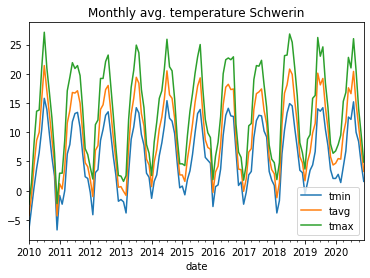

In [64]:
df[['tmin','tavg', 'tmax']].plot(title="Monthly avg. temperature Schwerin")

<AxesSubplot:title={'center':'Monthly precipitation Schwerin, 2010-2020'}, xlabel='date'>

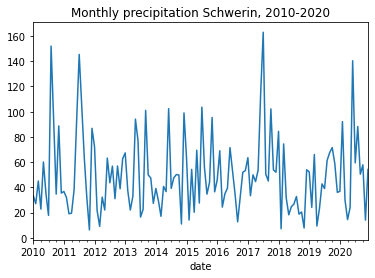

In [66]:
df['prcp'].plot(title="Monthly precipitation Schwerin, 2010-2020")

# Extracting temperature averages over the years
We pivot the data to show us the values for each month and year

In [47]:
monthly_temp = pd.pivot_table(df,index=df.index.month,columns=df.index.year,
                         values='tavg',aggfunc=np.max)

monthly_temp

date,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
date,,,,,,,,,,,
1,-4.2,1.2,1.9,0.7,0.7,2.7,-0.3,-0.1,2.9,1.7,4.7
2,-0.9,0.3,-1.0,-0.1,4.9,1.6,3.2,2.0,-1.2,5.0,5.5
3,4.4,4.0,6.9,-0.8,7.0,5.4,4.2,6.6,1.4,6.6,5.4
4,8.6,11.6,7.7,7.5,10.6,8.2,7.8,7.2,11.3,9.9,9.7
5,10.0,13.7,13.9,13.1,12.6,11.4,14.7,13.9,16.7,11.5,11.8
6,15.8,16.8,14.7,15.8,15.8,15.1,17.7,16.6,18.1,20.1,17.6
7,21.4,16.7,17.3,19.4,20.5,17.9,18.2,16.9,20.8,18.1,16.6
8,17.1,17.1,18.0,18.4,16.4,19.3,17.3,17.4,19.9,19.2,20.4
9,13.1,15.0,13.7,13.2,15.8,13.4,17.4,13.7,15.4,14.3,14.9


<AxesSubplot:title={'center':'0.9 Confidence interval for average monthly temperature'}>

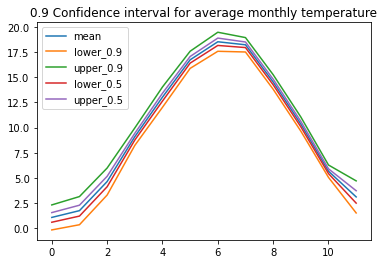

In [67]:
temp_bounds = pd.DataFrame([sample(row[1].values, [CONFIDENCE, 0.5]) for row in monthly_temp.iterrows()])

temp_bounds.plot(title=f"{CONFIDENCE} Confidence interval for average monthly temperature")

In [68]:
temp_bounds.to_csv(f"temp_bounds_{CONFIDENCE}_meteostat.csv", index=False)

# Extracting Precipitation totals over the years

In [18]:
monthly_prec = pd.pivot_table(df,index=df.index.month,columns=df.index.year,
                         values='prcp',aggfunc=np.max)

monthly_prec

date,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
date,,,,,,,,,,,
1,33.6,36.7,72.2,67.3,39.1,63.0,45.8,63.5,84.4,52.3,36.8
2,27.0,32.0,21.7,37.5,29.3,14.0,69.0,33.3,7.1,24.1,92.1
3,45.0,19.0,9.0,22.0,17.0,54.2,24.3,49.9,74.4,66.0,30.0
4,22.7,19.5,32.2,32.9,40.7,20.2,34.8,44.5,31.6,9.3,14.4
5,60.1,38.0,22.0,94.1,36.6,69.4,39.3,53.6,18.2,23.0,24.0
6,34.8,93.2,63.2,77.2,102.4,27.5,71.5,114.3,24.6,42.7,140.4
7,17.7,145.4,43.6,16.4,39.1,103.6,52.9,163.0,26.7,39.0,59.4
8,152.0,104.0,56.8,22.5,47.5,55.9,34.3,50.4,32.7,61.3,88.2
9,92.0,63.0,31.0,101.0,50.1,34.6,12.6,45.0,18.7,67.5,50.4


<AxesSubplot:title={'center':'0.9 Confidence interval for average monthly precipitation'}>

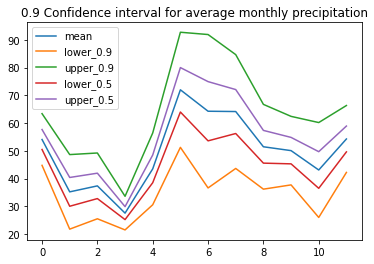

In [69]:
prec_bounds = pd.DataFrame([sample(row[1].values, [CONFIDENCE,0.5]) for row in monthly_prec.iterrows()])

prec_bounds.plot(title=f"{CONFIDENCE} Confidence interval for average monthly precipitation")

In [70]:
prec_bounds.to_csv(f"prec_bounds_{CONFIDENCE}_meteostat.csv", index=False)

# 3. Querying Evaporation from DWD data

In [21]:
station_index_url = "https://opendata.dwd.de/climate_environment/CDC/derived_germany/soil/monthly/historical/derived_germany_soil_monthly_historical_stations_list.txt"
station_url = lambda x : f"https://opendata.dwd.de/climate_environment/CDC/derived_germany/soil/monthly/historical/derived_germany_soil_monthly_historical_{x}.txt.gz"

In [22]:
s = requests.get(station_index_url).text
s = re.sub(r" {2,}", "", s)
station_index = pd.read_csv(io.StringIO(s), delimiter=';')
station_index = gpd.GeoDataFrame(
    station_index, 
    geometry=gpd.points_from_xy(
        station_index['Breite'], 
        station_index['Länge']
    )
)
station_index['distance'] = station_index.distance(loc_pnt)
station_index.head()

,Stationsindex,Höhe in m,Breite,Länge,Name,Bundesland,geometry,distance
0,44,44,52.93,8.24,Großenkneten,Niedersachsen,POINT (52.93000 8.24000),3.388285
1,73,340,48.62,13.05,Aldersbach-Kriestorf,Bayern,POINT (48.62000 13.05000),5.301373
2,78,65,52.49,7.91,Alfhausen,Niedersachsen,POINT (52.49000 7.91000),3.826155
3,91,300,50.75,9.35,Alsfeld-Eifa,Hessen,POINT (50.75000 9.35000),3.674860
4,96,50,52.94,12.85,Neuruppin-Alt Ruppin,Brandenburg,POINT (52.94000 12.85000),1.515913


In [23]:
closest_station = station_index.sort_values(by='distance').iloc[0]
print(closest_station)

Stationsindex                      4625
 Höhe in m                           59
Breite                            53.64
Länge                             11.39
Name                           Schwerin
Bundesland       Mecklenburg-Vorpommern
geometry            POINT (53.64 11.39)
distance                       0.161463
Name: 322, dtype: object


In [25]:
s = requests.get(station_url(closest_station['Stationsindex'])).content
s = gzip.decompress(s).decode('utf-8')
df = pd.read_csv(io.StringIO(s), delimiter=';')
df['month'] = df['Monat'].apply(lambda x : str(x)[-2:])
df['year'] = df['Monat'].apply(lambda x : str(x)[:-2])
df = df.rename(columns={"Summe von VGSL":"evap"})

df.head()

,Stationsindex,Monat,evap,Summe von VPGB,Summe von VPGH,Mittel von TS05,Mittel von TS10,Mittel von TS20,Mittel von TS50,Mittel von TS100,...,Summe von VPZB,Summe von VGLS,Summe von VWLS,Summe von VWSL,Mittel von BFWLS,Mittel von BFWSL,eor,Unnamed: 33,month,year
0,4625,199101,16.4,16.5,13.2,1.2,1.4,1.8,2.9,4.4,...,12.7,16.2,13.8,14.4,104.1,103.3,eor,NaN,01,1991
1,4625,199102,8.0,8.0,10.1,-0.7,-0.4,0.0,1.2,2.8,...,7.0,7.9,7.1,7.3,104.9,104.0,eor,NaN,02,1991
2,4625,199103,32.3,37.8,29.8,6.7,6.5,6.1,5.3,4.8,...,33.0,30.6,20.3,23.4,97.0,98.6,eor,NaN,03,1991
3,4625,199104,48.0,58.5,53.4,9.7,9.6,9.4,8.7,7.9,...,49.7,37.1,28.4,31.3,84.3,91.1,eor,NaN,04,1991
4,4625,199105,42.3,74.3,55.2,12.9,12.7,12.2,10.8,9.5,...,63.6,32.4,54.8,58.9,74.0,84.1,eor,NaN,05,1991


In [27]:
monthly_evap = pd.pivot_table(df,
                              index=df['month'],
                              columns=df['year'],
                              values='evap',
                              aggfunc=np.max)

monthly_evap

year,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
month,,,,,,,,,,,,,,,,,,,,,
01,16.4,11.0,23.5,19.2,12.9,0.6,4.6,13.5,10.6,11.0,...,5.0,10.1,5.3,6.0,13.9,6.3,6.6,12.6,12.0,14.2
02,8.0,16.7,6.6,6.4,23.9,4.5,24.0,18.0,13.7,22.3,...,12.2,10.5,6.3,20.7,11.7,20.4,12.9,8.7,23.2,30.8
03,32.3,33.3,27.5,36.2,36.3,19.1,33.3,35.8,31.2,30.0,...,31.2,35.2,16.9,32.7,34.3,27.4,37.5,20.2,37.9,42.7
04,48.0,51.0,62.1,53.5,54.9,49.3,50.0,45.2,54.1,52.2,...,54.8,45.3,50.8,57.2,55.9,53.0,49.0,61.2,53.3,41.1
05,42.3,76.9,36.8,57.1,64.9,53.0,67.1,62.3,71.9,53.8,...,42.2,45.9,69.6,54.8,60.2,64.1,82.6,47.6,41.3,37.4
06,59.9,25.8,69.7,74.6,69.4,50.6,68.8,74.0,45.3,48.3,...,67.7,40.2,83.8,50.4,30.3,92.6,66.5,32.6,68.0,51.5
07,75.0,74.6,79.8,40.6,38.7,33.9,54.1,81.4,60.4,43.0,...,79.4,67.9,49.7,91.4,78.1,91.2,84.6,45.2,64.7,53.1
08,43.7,43.4,64.3,50.9,25.0,49.1,43.3,66.6,35.5,68.6,...,67.6,37.0,27.5,58.6,75.8,53.7,70.5,25.7,83.1,35.5
09,22.4,34.8,33.6,35.2,35.8,25.7,16.1,31.6,22.7,35.4,...,43.7,28.3,35.5,25.3,36.4,25.8,39.4,27.8,45.5,31.6


<AxesSubplot:title={'center':'0.9 Confidence interval for average monthly evaporation'}>

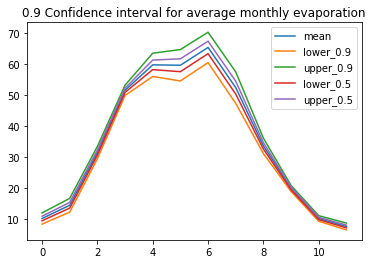

In [71]:
evap_bounds = pd.DataFrame([sample(row[1].values, [CONFIDENCE,0.5]) for row in monthly_evap.iterrows()])

evap_bounds.plot(title=f"{CONFIDENCE} Confidence interval for average monthly evaporation")

In [72]:
evap_bounds.to_csv(f"evap_bounds_{CONFIDENCE}_dwd.csv", index=False)